<a href="https://colab.research.google.com/github/fasfaisa/ResEmotNet_FaceEmotion_Recognition/blob/main/FinalResEmoteNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Check for available device
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/RAF-DB.zip"
extract_path = "/content/drive/MyDrive/RAF-DB"

# Extract only if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(drive_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Define emotion class names
emotion_names = [
    'Surprised',
    'Fearful',
    'Disgusted',
    'Happy',
    'Sad',
    'Angry',
    'Neutral'
]

Using cuda device
Mounted at /content/drive


In [9]:
class RAFDB(Dataset):
    def __init__(self, img_dir, label_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Read the label file
        df = pd.read_csv(label_file)
        print(f"Label file columns: {df.columns.tolist()}")

        # Assuming first column is filename, second column is label
        filename_col = df.columns[0]
        label_col = df.columns[1]

        filenames_raw = df[filename_col].tolist()
        labels_raw = df[label_col].tolist()

        # Find all image files in the directory structure
        all_image_paths = []
        for root, dirs, files in os.walk(img_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    all_image_paths.append(os.path.join(root, file))

        print(f"Found {len(all_image_paths)} total image files in directory structure")

        # Check if exact filenames match
        self.filenames = []
        self.valid_labels = []

        for i, raw_name in enumerate(filenames_raw):
            # Try to find the file by its base name
            base_name = os.path.basename(raw_name)
            matching_files = [p for p in all_image_paths if os.path.basename(p) == base_name]

            if matching_files:
                self.filenames.append(matching_files[0])  # Use the first match
                # Convert 1-indexed labels to 0-indexed
                self.valid_labels.append(labels_raw[i] - 1)  # Subtract 1 to make 0-indexed

        print(f"Successfully matched {len(self.filenames)} out of {len(filenames_raw)} files")

        # Print some label statistics after conversion
        unique_labels = sorted(set(self.valid_labels))
        print(f"After converting to 0-indexed, unique labels are: {unique_labels}")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.filenames[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.valid_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:

# SE Block for attention mechanism
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)



In [4]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class ResEmoteNet(nn.Module):
    def __init__(self, num_classes=7):
        super(ResEmoteNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(256)

        self.res_block1 = ResidualBlock(256, 512, stride=2)
        self.res_block2 = ResidualBlock(512, 1024, stride=2)
        self.res_block3 = ResidualBlock(1024, 2048, stride=2)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.se(x)

        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        x = self.pool(x)
        x = x.view(x.size(0), -1) # Flatten before fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

In [6]:

def save_model_to_drive(model, optimizer, epoch, best_acc,
                         train_losses, test_losses,
                         train_accuracies, test_accuracies):
    # Specify path in Google Drive
    drive_save_path = '/content/drive/MyDrive/emotion_models/rafdb_final_model.pth'

    # Ensure directory exists
    os.makedirs(os.path.dirname(drive_save_path), exist_ok=True)

    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'best_acc': best_acc,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }, drive_save_path)
    print(f"Final model saved to {drive_save_path}")

In [7]:

def plot_detailed_confusion_matrix(y_true, y_pred):
    """
    Create a detailed confusion matrix visualization with emotion names
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a figure with two subplots
    plt.figure(figsize=(16, 7))

    # Absolute values subplot
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_names,
                yticklabels=emotion_names)
    plt.title('Confusion Matrix (Absolute Values)')
    plt.xlabel('Predicted Emotion')
    plt.ylabel('True Emotion')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Normalized subplot
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlGnBu',
                xticklabels=emotion_names,
                yticklabels=emotion_names)
    plt.title('Confusion Matrix (Normalized)')
    plt.xlabel('Predicted Emotion')
    plt.ylabel('True Emotion')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/emotion_models/detailed_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.close()

    return cm, cm_normalized

In [8]:


def main():
    # Transform the dataset
    transform_train = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.RandomCrop(96),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),  # New: Random rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # New: Color jittering
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # This part was indented causing the error
    # Corrected the indentation here
    transform_test = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.CenterCrop(96),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

     # Path configuration for RAF-DB
    base_dir = '/content/drive/MyDrive'  # Changed base_dir to include the Google Drive path
    train_img_dir = os.path.join(base_dir, 'RAF-DB/DATASET/train')
    test_img_dir = os.path.join(base_dir, 'RAF-DB/DATASET/test')
    train_label_file = os.path.join(base_dir, 'RAF-DB/train_labels.csv')  # Updated path
    test_label_file = os.path.join(base_dir, 'RAF-DB/test_labels.csv')  # Updated path


    # Check if paths exist
    print(f"Train images directory exists: {os.path.exists(train_img_dir)}")
    print(f"Test images directory exists: {os.path.exists(test_img_dir)}")
    print(f"Train label file exists: {os.path.exists(train_label_file)}")
    print(f"Test label file exists: {os.path.exists(test_label_file)}")

    # Load datasets
    train_dataset = RAFDB(
        img_dir=train_img_dir,
        label_file=train_label_file,
        transform=transform_train
    )

    test_dataset = RAFDB(
        img_dir=test_img_dir,
        label_file=test_label_file,
        transform=transform_test
    )

    # Check the range of labels
    all_labels = train_dataset.valid_labels + test_dataset.valid_labels
    unique_labels = sorted(set(all_labels))
    print(f"Unique labels in dataset: {unique_labels}")
    num_classes = max(unique_labels) + 1
    print(f"Setting num_classes to {num_classes}")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

    # Initialize model with the correct number of classes
    num_classes = 7  # Assuming 0-6 are the valid classes
    model = ResEmoteNet(num_classes=num_classes).to(device)
    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    print(f"Training with {len(train_dataset)} images, testing with {len(test_dataset)} images")

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)  # Adam instead of SGD
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)  # New: Cosine LR schedule

    # Training parameters
    num_epochs = 80
    best_acc = 0.0
    patience = 15
    patience_counter = 0

    # Lists to store metrics
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Train phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Test phase
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(test_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_loss /= len(test_loader)
        test_acc = 100. * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Update learning rate
        scheduler.step(test_acc)

        # Print epoch results
        print(f'Epoch: {epoch+1} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f}% | Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.3f}%')

        # Save best model
        if test_acc > best_acc:
            print(f'Saving best model with accuracy: {test_acc:.3f}%')
            best_acc = test_acc
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs. Best accuracy: {best_acc:.3f}%")

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping after {patience} epochs without improvement")
            break

    # Save final model to Google Drive
    save_model_to_drive(model, optimizer, epoch, best_acc,
                         train_losses, test_losses,
                         train_accuracies, test_accuracies)

    # Save final results
    results_df = pd.DataFrame({
        'Epoch': range(1, len(train_losses) + 1),
        'Train Loss': train_losses,
        'Test Loss': test_losses,
        'Train Accuracy': train_accuracies,
        'Test Accuracy': test_accuracies
    })
    results_df.to_csv('/content/drive/MyDrive/emotion_models/rafdb_results.csv', index=False)

    # Plot training curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/emotion_models/rafdb_training_curves.png')
    plt.close()

    print(f"Best test accuracy: {best_acc:.3f}%")

    # Evaluation and Confusion Matrix
    # Recreate the model architecture
    model = ResEmoteNet(num_classes=num_classes).to(device)

    # Load the saved model state
    checkpoint = torch.load('/content/drive/MyDrive/emotion_models/rafdb_final_model.pth')
    model.load_state_dict(checkpoint['model'])
    model.eval()

    # Collect true and predicted labels
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Generate detailed confusion matrix
    cm, cm_normalized = plot_detailed_confusion_matrix(y_true, y_pred)

    # Print classification report with emotion names
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=emotion_names))

    # Emotion-wise accuracy visualization
    plt.figure(figsize=(10, 6))
    class_accuracy = [sum((np.array(y_true) == c) & (np.array(y_pred) == c)) / sum(np.array(y_true) == c) * 100
                      for c in range(num_classes)]

    plt.bar(range(num_classes), class_accuracy)
    plt.title('Accuracy per Emotion')
    plt.xlabel('Emotion')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(num_classes), emotion_names, rotation=45)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/emotion_models/class_accuracy.png', dpi=300, bbox_inches='tight')
    plt.close()

    print("\nEmotion-wise Accuracy:")
    for c, acc in enumerate(class_accuracy):
        print(f"{emotion_names[c]}: {acc:.2f}%")

if __name__ == "__main__":
    main()

Train images directory exists: True
Test images directory exists: True
Train label file exists: True
Test label file exists: True
Label file columns: ['image', 'label']
Found 12271 total image files in directory structure
Successfully matched 12271 out of 12271 files
After converting to 0-indexed, unique labels are: [0, 1, 2, 3, 4, 5, 6]
Label file columns: ['image', 'label']
Found 3068 total image files in directory structure
Successfully matched 3068 out of 3068 files
After converting to 0-indexed, unique labels are: [0, 1, 2, 3, 4, 5, 6]
Unique labels in dataset: [0, 1, 2, 3, 4, 5, 6]
Setting num_classes to 7
80,238,599 total parameters.
Training with 12271 images, testing with 3068 images


Epoch 1/80: 100%|██████████| 192/192 [00:58<00:00,  3.27it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 | Train Loss: 1.532 | Train Acc: 42.776% | Test Loss: 1.358 | Test Acc: 52.021%
Saving best model with accuracy: 52.021%


Epoch 2/80: 100%|██████████| 192/192 [00:53<00:00,  3.61it/s]


Epoch: 2 | Train Loss: 1.332 | Train Acc: 51.088% | Test Loss: 1.229 | Test Acc: 53.585%
Saving best model with accuracy: 53.585%


Epoch 3/80: 100%|██████████| 192/192 [00:53<00:00,  3.60it/s]


Epoch: 3 | Train Loss: 1.286 | Train Acc: 53.720% | Test Loss: 1.167 | Test Acc: 58.963%
Saving best model with accuracy: 58.963%


Epoch 4/80: 100%|██████████| 192/192 [00:54<00:00,  3.56it/s]


Epoch: 4 | Train Loss: 1.246 | Train Acc: 56.132% | Test Loss: 1.231 | Test Acc: 58.279%
No improvement for 1 epochs. Best accuracy: 58.963%


Epoch 5/80: 100%|██████████| 192/192 [00:52<00:00,  3.63it/s]


Epoch: 5 | Train Loss: 1.206 | Train Acc: 57.779% | Test Loss: 1.117 | Test Acc: 61.538%
Saving best model with accuracy: 61.538%


Epoch 6/80: 100%|██████████| 192/192 [00:54<00:00,  3.56it/s]


Epoch: 6 | Train Loss: 1.158 | Train Acc: 60.011% | Test Loss: 1.015 | Test Acc: 63.787%
Saving best model with accuracy: 63.787%


Epoch 7/80: 100%|██████████| 192/192 [00:54<00:00,  3.53it/s]


Epoch: 7 | Train Loss: 1.106 | Train Acc: 60.802% | Test Loss: 1.018 | Test Acc: 63.885%
Saving best model with accuracy: 63.885%


Epoch 8/80: 100%|██████████| 192/192 [00:53<00:00,  3.62it/s]


Epoch: 8 | Train Loss: 1.059 | Train Acc: 63.581% | Test Loss: 0.930 | Test Acc: 69.394%
Saving best model with accuracy: 69.394%


Epoch 9/80: 100%|██████████| 192/192 [00:53<00:00,  3.61it/s]


Epoch: 9 | Train Loss: 0.979 | Train Acc: 66.604% | Test Loss: 0.815 | Test Acc: 72.229%
Saving best model with accuracy: 72.229%


Epoch 10/80: 100%|██████████| 192/192 [00:53<00:00,  3.59it/s]


Epoch: 10 | Train Loss: 0.904 | Train Acc: 69.611% | Test Loss: 0.803 | Test Acc: 71.806%
No improvement for 1 epochs. Best accuracy: 72.229%


Epoch 11/80: 100%|██████████| 192/192 [00:52<00:00,  3.63it/s]


Epoch: 11 | Train Loss: 0.885 | Train Acc: 70.410% | Test Loss: 0.738 | Test Acc: 74.218%
Saving best model with accuracy: 74.218%


Epoch 12/80: 100%|██████████| 192/192 [00:53<00:00,  3.57it/s]


Epoch: 12 | Train Loss: 0.825 | Train Acc: 72.089% | Test Loss: 0.697 | Test Acc: 76.076%
Saving best model with accuracy: 76.076%


Epoch 13/80: 100%|██████████| 192/192 [00:51<00:00,  3.73it/s]


Epoch: 13 | Train Loss: 0.778 | Train Acc: 73.384% | Test Loss: 0.680 | Test Acc: 76.499%
Saving best model with accuracy: 76.499%


Epoch 14/80: 100%|██████████| 192/192 [00:50<00:00,  3.82it/s]


Epoch: 14 | Train Loss: 0.745 | Train Acc: 74.957% | Test Loss: 0.648 | Test Acc: 77.705%
Saving best model with accuracy: 77.705%


Epoch 15/80: 100%|██████████| 192/192 [00:51<00:00,  3.75it/s]


Epoch: 15 | Train Loss: 0.704 | Train Acc: 76.261% | Test Loss: 0.638 | Test Acc: 78.520%
Saving best model with accuracy: 78.520%


Epoch 16/80: 100%|██████████| 192/192 [00:50<00:00,  3.81it/s]


Epoch: 16 | Train Loss: 0.674 | Train Acc: 77.426% | Test Loss: 0.597 | Test Acc: 79.824%
Saving best model with accuracy: 79.824%


Epoch 17/80: 100%|██████████| 192/192 [00:50<00:00,  3.77it/s]


Epoch: 17 | Train Loss: 0.645 | Train Acc: 78.421% | Test Loss: 0.610 | Test Acc: 80.150%
Saving best model with accuracy: 80.150%


Epoch 18/80: 100%|██████████| 192/192 [00:50<00:00,  3.83it/s]


Epoch: 18 | Train Loss: 0.619 | Train Acc: 79.007% | Test Loss: 0.565 | Test Acc: 80.020%
No improvement for 1 epochs. Best accuracy: 80.150%


Epoch 19/80: 100%|██████████| 192/192 [00:50<00:00,  3.78it/s]


Epoch: 19 | Train Loss: 0.598 | Train Acc: 80.132% | Test Loss: 0.596 | Test Acc: 80.183%
Saving best model with accuracy: 80.183%


Epoch 20/80: 100%|██████████| 192/192 [00:50<00:00,  3.79it/s]


Epoch: 20 | Train Loss: 0.568 | Train Acc: 81.289% | Test Loss: 0.570 | Test Acc: 81.160%
Saving best model with accuracy: 81.160%


Epoch 21/80: 100%|██████████| 192/192 [00:50<00:00,  3.78it/s]


Epoch: 21 | Train Loss: 0.543 | Train Acc: 81.876% | Test Loss: 0.561 | Test Acc: 81.519%
Saving best model with accuracy: 81.519%


Epoch 22/80: 100%|██████████| 192/192 [00:50<00:00,  3.79it/s]


Epoch: 22 | Train Loss: 0.520 | Train Acc: 83.009% | Test Loss: 0.550 | Test Acc: 81.584%
Saving best model with accuracy: 81.584%


Epoch 23/80: 100%|██████████| 192/192 [00:49<00:00,  3.87it/s]


Epoch: 23 | Train Loss: 0.496 | Train Acc: 83.856% | Test Loss: 0.583 | Test Acc: 81.551%
No improvement for 1 epochs. Best accuracy: 81.584%


Epoch 24/80: 100%|██████████| 192/192 [00:50<00:00,  3.81it/s]


Epoch: 24 | Train Loss: 0.486 | Train Acc: 84.190% | Test Loss: 0.560 | Test Acc: 82.399%
Saving best model with accuracy: 82.399%


Epoch 25/80: 100%|██████████| 192/192 [00:49<00:00,  3.86it/s]


Epoch: 25 | Train Loss: 0.456 | Train Acc: 85.005% | Test Loss: 0.548 | Test Acc: 82.660%
Saving best model with accuracy: 82.660%


Epoch 26/80: 100%|██████████| 192/192 [00:50<00:00,  3.80it/s]


Epoch: 26 | Train Loss: 0.432 | Train Acc: 86.114% | Test Loss: 0.582 | Test Acc: 81.845%
No improvement for 1 epochs. Best accuracy: 82.660%


Epoch 27/80: 100%|██████████| 192/192 [00:51<00:00,  3.74it/s]


Epoch: 27 | Train Loss: 0.439 | Train Acc: 85.926% | Test Loss: 0.540 | Test Acc: 82.529%
No improvement for 2 epochs. Best accuracy: 82.660%


Epoch 28/80: 100%|██████████| 192/192 [00:51<00:00,  3.74it/s]


Epoch: 28 | Train Loss: 0.400 | Train Acc: 87.067% | Test Loss: 0.559 | Test Acc: 82.692%
Saving best model with accuracy: 82.692%


Epoch 29/80: 100%|██████████| 192/192 [00:50<00:00,  3.79it/s]


Epoch: 29 | Train Loss: 0.389 | Train Acc: 87.523% | Test Loss: 0.559 | Test Acc: 82.920%
Saving best model with accuracy: 82.920%


Epoch 30/80: 100%|██████████| 192/192 [00:50<00:00,  3.80it/s]


Epoch: 30 | Train Loss: 0.378 | Train Acc: 87.809% | Test Loss: 0.564 | Test Acc: 82.660%
No improvement for 1 epochs. Best accuracy: 82.920%


Epoch 31/80: 100%|██████████| 192/192 [00:50<00:00,  3.81it/s]


Epoch: 31 | Train Loss: 0.368 | Train Acc: 88.078% | Test Loss: 0.586 | Test Acc: 81.714%
No improvement for 2 epochs. Best accuracy: 82.920%


Epoch 32/80: 100%|██████████| 192/192 [00:49<00:00,  3.89it/s]


Epoch: 32 | Train Loss: 0.370 | Train Acc: 88.045% | Test Loss: 0.572 | Test Acc: 82.301%
No improvement for 3 epochs. Best accuracy: 82.920%


Epoch 33/80: 100%|██████████| 192/192 [00:50<00:00,  3.80it/s]


Epoch: 33 | Train Loss: 0.357 | Train Acc: 88.363% | Test Loss: 0.574 | Test Acc: 83.018%
Saving best model with accuracy: 83.018%


Epoch 34/80: 100%|██████████| 192/192 [00:49<00:00,  3.86it/s]


Epoch: 34 | Train Loss: 0.332 | Train Acc: 89.675% | Test Loss: 0.598 | Test Acc: 81.975%
No improvement for 1 epochs. Best accuracy: 83.018%


Epoch 35/80: 100%|██████████| 192/192 [00:51<00:00,  3.74it/s]


Epoch: 35 | Train Loss: 0.338 | Train Acc: 89.088% | Test Loss: 0.582 | Test Acc: 82.660%
No improvement for 2 epochs. Best accuracy: 83.018%


Epoch 36/80: 100%|██████████| 192/192 [00:51<00:00,  3.76it/s]


Epoch: 36 | Train Loss: 0.307 | Train Acc: 90.164% | Test Loss: 0.605 | Test Acc: 82.073%
No improvement for 3 epochs. Best accuracy: 83.018%


Epoch 37/80: 100%|██████████| 192/192 [00:52<00:00,  3.66it/s]


Epoch: 37 | Train Loss: 0.314 | Train Acc: 89.952% | Test Loss: 0.640 | Test Acc: 82.106%
No improvement for 4 epochs. Best accuracy: 83.018%


Epoch 38/80: 100%|██████████| 192/192 [00:50<00:00,  3.83it/s]


Epoch: 38 | Train Loss: 0.312 | Train Acc: 89.911% | Test Loss: 0.599 | Test Acc: 82.757%
No improvement for 5 epochs. Best accuracy: 83.018%


Epoch 39/80: 100%|██████████| 192/192 [00:50<00:00,  3.80it/s]


Epoch: 39 | Train Loss: 0.277 | Train Acc: 91.419% | Test Loss: 0.594 | Test Acc: 82.464%
No improvement for 6 epochs. Best accuracy: 83.018%


Epoch 40/80: 100%|██████████| 192/192 [00:49<00:00,  3.89it/s]


Epoch: 40 | Train Loss: 0.280 | Train Acc: 91.142% | Test Loss: 0.615 | Test Acc: 81.812%
No improvement for 7 epochs. Best accuracy: 83.018%


Epoch 41/80: 100%|██████████| 192/192 [00:50<00:00,  3.80it/s]


Epoch: 41 | Train Loss: 0.278 | Train Acc: 91.182% | Test Loss: 0.588 | Test Acc: 82.269%
No improvement for 8 epochs. Best accuracy: 83.018%


Epoch 42/80: 100%|██████████| 192/192 [00:50<00:00,  3.78it/s]


Epoch: 42 | Train Loss: 0.262 | Train Acc: 91.565% | Test Loss: 0.611 | Test Acc: 82.855%
No improvement for 9 epochs. Best accuracy: 83.018%


Epoch 43/80: 100%|██████████| 192/192 [00:50<00:00,  3.82it/s]


Epoch: 43 | Train Loss: 0.244 | Train Acc: 92.193% | Test Loss: 0.642 | Test Acc: 82.562%
No improvement for 10 epochs. Best accuracy: 83.018%


Epoch 44/80: 100%|██████████| 192/192 [00:50<00:00,  3.78it/s]


Epoch: 44 | Train Loss: 0.230 | Train Acc: 92.568% | Test Loss: 0.673 | Test Acc: 81.747%
No improvement for 11 epochs. Best accuracy: 83.018%


Epoch 45/80: 100%|██████████| 192/192 [00:48<00:00,  3.93it/s]


Epoch: 45 | Train Loss: 0.257 | Train Acc: 91.843% | Test Loss: 0.627 | Test Acc: 82.595%
No improvement for 12 epochs. Best accuracy: 83.018%


Epoch 46/80: 100%|██████████| 192/192 [00:50<00:00,  3.83it/s]


Epoch: 46 | Train Loss: 0.212 | Train Acc: 93.587% | Test Loss: 0.672 | Test Acc: 82.269%
No improvement for 13 epochs. Best accuracy: 83.018%


Epoch 47/80: 100%|██████████| 192/192 [00:49<00:00,  3.87it/s]


Epoch: 47 | Train Loss: 0.222 | Train Acc: 92.812% | Test Loss: 0.610 | Test Acc: 83.833%
Saving best model with accuracy: 83.833%


Epoch 48/80: 100%|██████████| 192/192 [00:50<00:00,  3.80it/s]


Epoch: 48 | Train Loss: 0.191 | Train Acc: 93.945% | Test Loss: 0.666 | Test Acc: 83.149%
No improvement for 1 epochs. Best accuracy: 83.833%


Epoch 49/80: 100%|██████████| 192/192 [00:50<00:00,  3.84it/s]


Epoch: 49 | Train Loss: 0.191 | Train Acc: 93.896% | Test Loss: 0.633 | Test Acc: 83.279%
No improvement for 2 epochs. Best accuracy: 83.833%


Epoch 50/80: 100%|██████████| 192/192 [00:48<00:00,  3.92it/s]


Epoch: 50 | Train Loss: 0.179 | Train Acc: 94.328% | Test Loss: 0.655 | Test Acc: 83.116%
No improvement for 3 epochs. Best accuracy: 83.833%


Epoch 51/80: 100%|██████████| 192/192 [00:51<00:00,  3.75it/s]


Epoch: 51 | Train Loss: 0.184 | Train Acc: 94.434% | Test Loss: 0.674 | Test Acc: 82.953%
No improvement for 4 epochs. Best accuracy: 83.833%


Epoch 52/80: 100%|██████████| 192/192 [00:49<00:00,  3.85it/s]


Epoch: 52 | Train Loss: 0.177 | Train Acc: 94.336% | Test Loss: 0.665 | Test Acc: 83.768%
No improvement for 5 epochs. Best accuracy: 83.833%


Epoch 53/80: 100%|██████████| 192/192 [00:49<00:00,  3.84it/s]


Epoch: 53 | Train Loss: 0.165 | Train Acc: 94.956% | Test Loss: 0.676 | Test Acc: 83.116%
No improvement for 6 epochs. Best accuracy: 83.833%


Epoch 54/80: 100%|██████████| 192/192 [00:49<00:00,  3.85it/s]


Epoch: 54 | Train Loss: 0.152 | Train Acc: 95.290% | Test Loss: 0.753 | Test Acc: 82.138%
No improvement for 7 epochs. Best accuracy: 83.833%


Epoch 55/80: 100%|██████████| 192/192 [00:50<00:00,  3.79it/s]


Epoch: 55 | Train Loss: 0.174 | Train Acc: 94.630% | Test Loss: 0.715 | Test Acc: 82.595%
No improvement for 8 epochs. Best accuracy: 83.833%


Epoch 56/80: 100%|██████████| 192/192 [00:50<00:00,  3.84it/s]


Epoch: 56 | Train Loss: 0.168 | Train Acc: 94.670% | Test Loss: 0.729 | Test Acc: 81.421%
No improvement for 9 epochs. Best accuracy: 83.833%


Epoch 57/80: 100%|██████████| 192/192 [00:50<00:00,  3.80it/s]


Epoch: 57 | Train Loss: 0.200 | Train Acc: 94.035% | Test Loss: 0.694 | Test Acc: 81.975%
No improvement for 10 epochs. Best accuracy: 83.833%


Epoch 58/80: 100%|██████████| 192/192 [00:50<00:00,  3.81it/s]


Epoch: 58 | Train Loss: 0.183 | Train Acc: 94.230% | Test Loss: 0.691 | Test Acc: 82.106%
No improvement for 11 epochs. Best accuracy: 83.833%


Epoch 59/80: 100%|██████████| 192/192 [00:49<00:00,  3.87it/s]


Epoch: 59 | Train Loss: 0.168 | Train Acc: 95.004% | Test Loss: 0.692 | Test Acc: 82.497%
No improvement for 12 epochs. Best accuracy: 83.833%


Epoch 60/80: 100%|██████████| 192/192 [00:50<00:00,  3.76it/s]


Epoch: 60 | Train Loss: 0.163 | Train Acc: 95.290% | Test Loss: 0.705 | Test Acc: 82.040%
No improvement for 13 epochs. Best accuracy: 83.833%


Epoch 61/80: 100%|██████████| 192/192 [00:49<00:00,  3.86it/s]


Epoch: 61 | Train Loss: 0.170 | Train Acc: 94.621% | Test Loss: 0.718 | Test Acc: 82.399%
No improvement for 14 epochs. Best accuracy: 83.833%


Epoch 62/80: 100%|██████████| 192/192 [00:50<00:00,  3.78it/s]


Epoch: 62 | Train Loss: 0.160 | Train Acc: 95.192% | Test Loss: 0.701 | Test Acc: 82.432%
No improvement for 15 epochs. Best accuracy: 83.833%
Early stopping after 15 epochs without improvement
Final model saved to /content/drive/MyDrive/emotion_models/rafdb_final_model.pth
Best test accuracy: 83.833%

Classification Report:
              precision    recall  f1-score   support

   Surprised       0.83      0.85      0.84       329
     Fearful       0.63      0.55      0.59        74
   Disgusted       0.54      0.52      0.53       160
       Happy       0.92      0.92      0.92      1185
         Sad       0.77      0.78      0.78       478
       Angry       0.77      0.72      0.74       162
     Neutral       0.79      0.80      0.79       680

    accuracy                           0.82      3068
   macro avg       0.75      0.73      0.74      3068
weighted avg       0.82      0.82      0.82      3068


Emotion-wise Accuracy:
Surprised: 85.41%
Fearful: 55.41%
Disgusted: 51.88%



Emotion Detection Menu:
1. Upload Image
2. Webcam Detection
3. Exit
Enter your choice (1-3): 1
Image Upload Emotion Detection
1. Upload an image file
2. The script will detect faces and predict emotions


Saving ang.jpeg to ang.jpeg
Showing detections for ang.jpeg


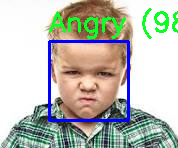


Emotion Detection Menu:
1. Upload Image
2. Webcam Detection
3. Exit
Enter your choice (1-3): 1
Image Upload Emotion Detection
1. Upload an image file
2. The script will detect faces and predict emotions


Saving sag.jpg to sag (10).jpg
Showing detections for sag (10).jpg


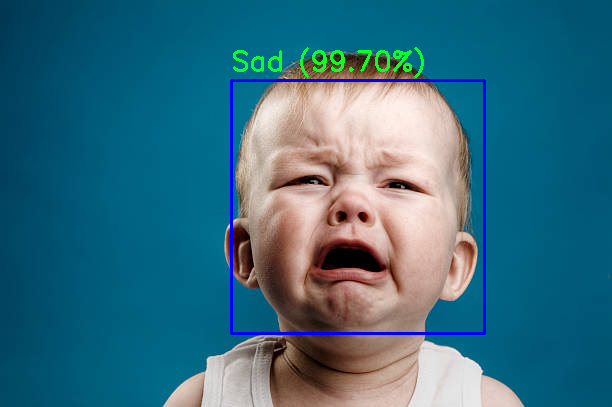


Emotion Detection Menu:
1. Upload Image
2. Webcam Detection
3. Exit


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files
import io

def detect_face(image):
    """
    Detect faces in an image using Haar Cascade Classifier
    """
    # Convert image to grayscale
    if isinstance(image, np.ndarray):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        # If it's a PIL Image, convert to numpy array first
        gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    # Load pre-trained face detection classifier
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    return faces

def colab_webcam_emotion_detection(model, device, transform):
    """
    Webcam emotion detection for Google Colab using camera module
    """
    print("Webcam Emotion Detection in Colab")
    print("1. Use the camera module to capture images")
    print("2. Close the camera window to stop")

    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    # JavaScript to capture image from browser's camera
    def take_photo(filename='photo.jpg', quality=0.8):
        js = Javascript('''
            async function takePhoto(quality) {
                const div = document.createElement('div');
                const capture = document.createElement('button');
                capture.textContent = 'Capture';
                div.appendChild(capture);

                const video = document.createElement('video');
                video.style.display = 'block';
                const stream = await navigator.mediaDevices.getUserMedia({video: true});

                document.body.appendChild(div);
                document.body.appendChild(video);

                video.srcObject = stream;
                await video.play();

                // Ensure camera is stable
                await new Promise(resolve => setTimeout(resolve, 1000));

                return new Promise((resolve, reject) => {
                    capture.onclick = () => {
                        const canvas = document.createElement('canvas');
                        canvas.width = video.videoWidth;
                        canvas.height = video.videoHeight;
                        canvas.getContext('2d').drawImage(video, 0, 0);
                        const image = canvas.toDataURL('image/jpeg', quality);
                        stream.getTracks()[0].stop();
                        document.body.removeChild(div);
                        document.body.removeChild(video);
                        google.colab.output.setIframeHeight(0, true, {maxHeight: 0});
                        resolve(image);
                    };

                    // Add cancel option
                    const cancel = document.createElement('button');
                    cancel.textContent = 'Cancel';
                    div.appendChild(cancel);
                    cancel.onclick = () => {
                        stream.getTracks()[0].stop();
                        document.body.removeChild(div);
                        document.body.removeChild(video);
                        google.colab.output.setIframeHeight(0, true, {maxHeight: 0});
                        resolve(null);
                    };
                });
            }
            takePhoto({})
        ''')
        display(js)
        data = eval_js('takePhoto({})'.format(quality))
        return data

    try:
        # Capture photo
        image_data = take_photo()

        # Check if image capture was cancelled
        if image_data is None:
            print("Image capture cancelled.")
            return

        # Decode the base64 image
        image_bytes = b64decode(image_data.split(',')[1])
        image_array = np.frombuffer(image_bytes, dtype=np.uint8)
        image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

        # Detect faces
        faces = detect_face(image)

        if len(faces) == 0:
            print("No faces detected in the image")
            return

        # Process each detected face
        for (x, y, w, h) in faces:
            # Extract face region
            face_frame = image[y:y+h, x:x+w]

            # Convert to PIL Image for model preprocessing
            pil_image = Image.fromarray(cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB))

            try:
                # Predict emotion
                emotion, confidence = predict_emotion(model, pil_image, device, transform)

                # Draw rectangle and emotion text
                cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
                label = f"{emotion} ({confidence:.2f}%)"
                cv2.putText(image, label, (x, y-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

            except Exception as e:
                print(f"Error processing face: {e}")

        # Display the image with detections
        print("Showing emotion detection results")
        cv2_imshow(image)

    except Exception as e:
        print(f"An error occurred: {e}")
def get_transform():
    """
    Returns the transformation pipeline for emotion detection
    """
    return transforms.Compose([
        transforms.Resize((96, 96)),  # Fixed size
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

def predict_emotion(model, image, device, transform):
    """
    Predicts the emotion in a given image.
    """
    # 1. Preprocess the image
    image = transform(image).unsqueeze(0).to(device)

    # 2. Get model predictions
    with torch.no_grad():
        outputs = model(image)  # Get model predictions
        _, predicted = torch.max(outputs, 1)  # Get predicted class

    # 3. Get emotion label and confidence
    emotion = emotion_names[predicted.item()]  # Access emotion label
    confidence = F.softmax(outputs, dim=1)[0][predicted.item()].item() * 100  # Use F.softmax

    return emotion, confidence
def load_model(model_path, num_classes=7):
    """
    Loads the saved model from the given path.
    """
    # Initialize the model with the correct number of classes
    model = ResEmoteNet(num_classes=num_classes).to(device)

    # Load the saved model state
    checkpoint = torch.load(model_path)

    # 1. Filter out unexpected keys
    filtered_state_dict = {k: v for k, v in checkpoint['model'].items() if k in model.state_dict()}

    # 2. Load the filtered state_dict into the model
    model.load_state_dict(filtered_state_dict, strict=False)
    # strict=False allows loading even if some keys are missing

    model.eval()
    return model, device


def main():
    # Path to your saved model (update this to match your Google Drive path)
    model_path = '/content/drive/MyDrive/emotion_models/rafdb_final_model.pth'
    model, device = load_model(model_path)

    transform = get_transform()

    # Menu for input selection
    while True:
        print("\nEmotion Detection Menu:")
        print("1. Upload Image")
        print("2. Webcam Detection")
        print("3. Exit")

        choice = input("Enter your choice (1-3): ")

        if choice == '1':
            upload_image_emotion_detection(model, device, transform)
        elif choice == '2':
            colab_webcam_emotion_detection(model, device, transform)
        elif choice == '3':
            print("Exiting the program.")
            break
        else:
            print("Invalid choice. Please try again.")

if __name__ == "__main__":
    main()